Plot for the Rissage paper: pressure time series in various locations around Mallorca.

In [1]:
import os
import netCDF4
import datetime
import calendar
import numpy as np
import logging
import importlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import ticker
from mpl_toolkits.basemap import Basemap
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Configuration

## Logging

In [2]:
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

## Period of interest

In [3]:
rcParams.update({'font.size': 26})
coordinates = (2., 4.5, 39.25, 40.25)
latgeonica, longeonica = 40.000215, 3.832001
year = 2014
month = 8
day = 18
BW = 1     # Switch to have the figure in Black and White

In [4]:
logger.debug("Working on month {0}, year {1}".format(month, year))

## Files and directories

In [19]:
yyyy = str(year)
mm = str(month).zfill(2)
dd = str(day).zfill(2)
if BW:
    figname = 'pressure_{0}{1}{2}_BW_rev.eps'.format(yyyy, mm, dd)
else:
    figname = 'pressure_{0}{1}{2}_color.eps'.format(yyyy, mm, dd)   

In [6]:
#figdir = "/home/ctroupin/Projects/1-Internal/201530627_Rissaga/figures/pressure_comparison"
figdir = "/home/ctroupin/Publis/UnderReview/201606_Rissaga/figures/"
stationdir = "http://thredds.socib.es/thredds/dodsC/mooring/"
stationlist = ['weather_station/buoy_bahiadepalma-scb_met008/L1/{0}/dep0002_buoy-bahiadepalma_scb-met008_L1_{0}-{1}.nc'.format(yyyy, mm),
               'weather_station/mobims_calamillor-scb_met001/L1/{0}/dep0001_mobims-calamillor_scb-met001_L1_{0}-{1}.nc'.format(yyyy, mm),
               'sea_level/station_pollensa/L1/{0}/dep20110701_station-pollensa_L1_{0}-{1}.nc'.format(yyyy, mm)]
#geonicadir = "/home/ctroupin/Projects/1-Internal/201530627_Rissaga/data_geonica/"
geonicadir = "/home/ctroupin/Publis/UnderReview/201606_Rissaga/data"
geonicafile = "Menorca_{0}-{1}-{2}.csv".format(dd, mm, yyyy)
stationnamelist = ['Bahia de Palma', 'Cala Millor', 'Pollensa']

In [7]:
logger.info("geonicafile = {0}".format(geonicafile))

## Time selection

In [8]:
timemin = (datetime.datetime(year, month, day, 12, 0, 0) - datetime.datetime(1970, 1, 1)).total_seconds()
timemax = (datetime.datetime(year, month, day + 1, 12, 0, 0) - datetime.datetime(1970, 1, 1)).total_seconds()
timeminday = (datetime.datetime(year, month, day, 12, 0, 0) - datetime.datetime(1, 1, 1)).days
timemaxday = (datetime.datetime(year, month, day + 1, 12, 0, 0) - datetime.datetime(1, 1, 1)).days

In [9]:
def read_station_pressure(stationfile, timemin, timemax):
    """Read the pressure from a netCDF file inside the specified interval.
    """
    with netCDF4.Dataset(stationfile) as nc:
        lon_name = nc.get_variables_by_attributes(standard_name='longitude')[0].name
        lat_name = nc.get_variables_by_attributes(standard_name='latitude')[0].name
        #lon_name, lat_name = 'LON', 'LAT'
        pressure_name = 'AIR_PRE'
        lon = nc.variables[lon_name][:]
        lat = nc.variables[lat_name][:]
        pressure_name = nc.get_variables_by_attributes(standard_name='air_pressure')[0].name
        time = nc.variables['time'][:]
        time_units = nc.variables['time'].units
        goodtime = np.where((time>=timemin) & (time<=timemax))[0]
        pressure = nc.variables[pressure_name][goodtime]
        time = time[goodtime]
        date = netCDF4.num2date(time, time_units)
        deltat = time[1] - time[0]
        return date, pressure, lon, lat, deltat

In [10]:
def read_geonica(datafile, valex= -999.):
    date = []
    pressure = []
    sealevel_min, sealevel_mean, sealevel_max = [], [], []
    with open(datafile, 'r') as f:
        firstline = f.readline()
        for lines in f.readlines():
            linesplit = lines.split(';')
            if not linesplit[1]:
                print("String is empty")
                pressure.append(valex)
            else:
                pressure.append(float(linesplit[1].replace(",", ".")))
            date.append(datetime.datetime.strptime(linesplit[0], '%d/%m/%Y %H:%M:%S'))
            sealevel_mean.append(0.1 * float(linesplit[2].replace(",", ".")))
            sealevel_max.append(0.1 * float(linesplit[3].replace(",", ".")))
            # sealevel_min.append(float(linesplit[4].replace(",", ".")))
    return date, pressure, sealevel_mean, sealevel_min, sealevel_max

In [11]:
date_ciutadella, pressure_ciutadella, sealevel_mean, sealevel_min, sealevel_max = \
read_geonica(os.path.join(geonicadir, geonicafile))

In [12]:
pressure_ciutadella

[1014.3989868164,
 1014.3900146484,
 1014.3759765625,
 1014.3800048828,
 1014.3189697266,
 1014.3099975586,
 1014.3010253906,
 1014.3040161133,
 1014.3170166016,
 1014.3070068359,
 1014.3010253906,
 1014.3010253906,
 1014.3040161133,
 1014.3010253906,
 1014.3010253906,
 1014.3010253906,
 1014.2819824219,
 1014.2680053711,
 1014.2650146484,
 1014.258972168,
 1014.2210083008,
 1014.2199707031,
 1014.216003418,
 1014.2059936523,
 1014.1989746094,
 1014.1989746094,
 1014.1859741211,
 1014.1959838867,
 1014.1729736328,
 1014.1389770508,
 1014.1010131836,
 1014.1040039062,
 1014.1010131836,
 1014.1010131836,
 1014.0590209961,
 1014.0230102539,
 1014.0130004883,
 1014.007019043,
 1014.0,
 1013.9970092773,
 1013.9970092773,
 1013.9409790039,
 1013.916015625,
 1013.9229736328,
 1013.9190063477,
 1013.9060058594,
 1013.9030151367,
 1013.8989868164,
 1013.8989868164,
 1013.9060058594,
 1013.9199829102,
 1013.9719848633,
 1013.992980957,
 1013.9829711914,
 1013.9769897461,
 1013.9409790039,
 1013.

# Make the plots

In [13]:
m = Basemap(projection='cyl',llcrnrlat=coordinates[2], urcrnrlat=coordinates[3],\
            llcrnrlon=coordinates[0], urcrnrlon=coordinates[1], resolution='h')

## Air pressure

In [20]:
if BW:
    colorlist = ["0.8", ".6", ".4", ".0"]

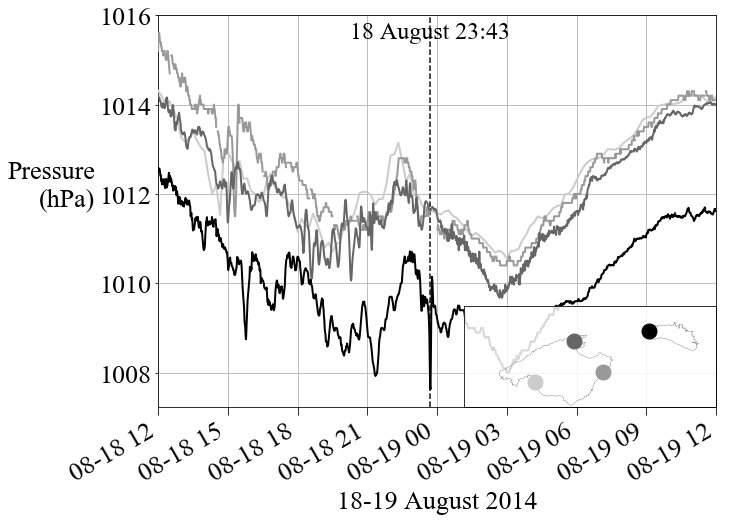

In [21]:
lon2plot, lat2plot = [], []

fig = plt.figure(figsize=(10, 8))
ax = plt.gca()
y_formatter = ticker.ScalarFormatter(useOffset=False)
ax.yaxis.set_major_formatter(y_formatter)

i = 0
for stations, stationname in zip(stationlist, stationnamelist):
    logger.info("Working on {0}".format(stationname))
    logger.info("File : {0}".format(os.path.join(stationdir, stations)))
    
    date, pressure, lon, lat, deltat = read_station_pressure(os.path.join(stationdir, stations), timemin, timemax)
    logger.info("lon = {0}, lat = {1}".format(lon, lat))

    pp = plt.plot(date, pressure, label=stationname, zorder=3, color=colorlist[i])
    i += 1
    pp[0].get_color()
    lon2plot.append(lon)
    lat2plot.append(lat)
    logger.info("Time interval : {0} s".format(deltat))
    
    
pp = plt.plot(date_ciutadella, pressure_ciutadella, label='Ciutadella', zorder=4, color=colorlist[i])

daterissaga = date_ciutadella[np.argmin(pressure_ciutadella)]
textrissaga = daterissaga.strftime("%d %B %H:%M")
plt.text(daterissaga, 1015.5, textrissaga, ha='center', fontsize=24)
plt.axvline(x=daterissaga, color='k', linestyle='--', zorder=2, alpha=0.7)
plt.xlabel(str(day) + '-' + str(day +1 ) + ' ' + calendar.month_name[month] + ' ' + yyyy)
plt.ylabel('Pressure\n(hPa)', rotation=0, ha='right')

# plt.legend(loc=4)
plt.grid()
ax.set_xlim(timeminday + 1.5, timemaxday + 1.5)
# ax.set_ylim(1005, 1016)
fig.autofmt_xdate()

inset = plt.axes([.55, .1625, .35, .25])
i = 0
for lon, lat in zip(lon2plot, lat2plot):
    m.plot(lon, lat, 'o', ms=15, color=colorlist[i])
    i += 1

inset.patch.set_alpha(0.85)
m.plot(longeonica, latgeonica, 'o', ms=15, color=colorlist[i])
m.drawcoastlines(linewidth=0.2)
plt.setp(inset, xticks=[], yticks=[])


plt.savefig(os.path.join(figdir, figname), dpi=300)
logger.info("File saves as {0}".format(os.path.join(figdir, figname)))
plt.show()
plt.close()

## Sea level

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = plt.gca()
y_formatter = ticker.ScalarFormatter(useOffset=False)
ax.yaxis.set_major_formatter(y_formatter)
plt.plot(date_ciutadella, sealevel_mean, color='k', lw=0.2)
plt.xlabel('19 August 2014', fontsize=22)
plt.ylabel('Sea level\n(cm)', rotation=0, ha='right', fontsize=22)
ax.set_xlim(timeminday + 1.5, timemaxday + 1.5)
fig.autofmt_xdate()
plt.grid
#plt.savefig('./sealevel_ciutadella_20140819.png', dpi=300)
plt.show()
plt.close()